# Face Detection System for Digital Cameras

This notebook implements a face recognition system based on machine learning techniques.
The system uses the WIDER FACE dataset accessible through Deeplake and builds a face detector from scratch.

## 1. Module Imports

Let's import all necessary modules for the project.

In [4]:
#%pip install --upgrade pip
#%pip install numpy==1.26.0  # Latest version compatible with Python 3.12
#%pip install scipy==1.13.0  # Version compatible with numpy 1.26.0
#%pip install opencv-python-headless==4.8.1.78  # Working version for Python 3.12
#%pip install scikit-learn==1.4.0  # Version compatible with numpy 1.26.0 and scipy 1.13.0
#%pip install scikit-image==0.22.0  # Version compatible with numpy 1.26.0

# After kernel restart, import libraries
import numpy as np
import cv2
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import skimage  # Add this line to import the full skimage module
from skimage.feature import hog, local_binary_pattern
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd

# Print versions to verify
print(f"NumPy version: {np.__version__}")
print(f"OpenCV version: {cv2.__version__}")
print(f"scikit-learn version: {sklearn_version}")
print(f"scikit-image version: {skimage.__version__}")
print("All modules imported successfully")

NumPy version: 1.26.4
OpenCV version: 4.8.1
scikit-learn version: 1.4.0
scikit-image version: 0.22.0
All modules imported successfully


# 2. Dataset Loading and Exploration

Accessing and exploring WIDER FACE dataset...


/usr/local/python/3.12.1/lib/python3.12/site-packages/humbug/report.py:47: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # type: ignore
/usr/local/python/3.12.1/lib/python3.12/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.2.14) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.2.14) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


Installed Deeplake version: 3.9.49


-

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/wider-face-train



|

hub://activeloop/wider-face-train loaded successfully.



-

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/wider-face-val



|

hub://activeloop/wider-face-val loaded successfully.



Train dataset: 12880 images
Validation dataset: 3226 images

Available tensors in the dataset:
['images', 'boxes', 'poses', 'expressions', 'illuminations', 'occlusions', 'validities', 'blurs']


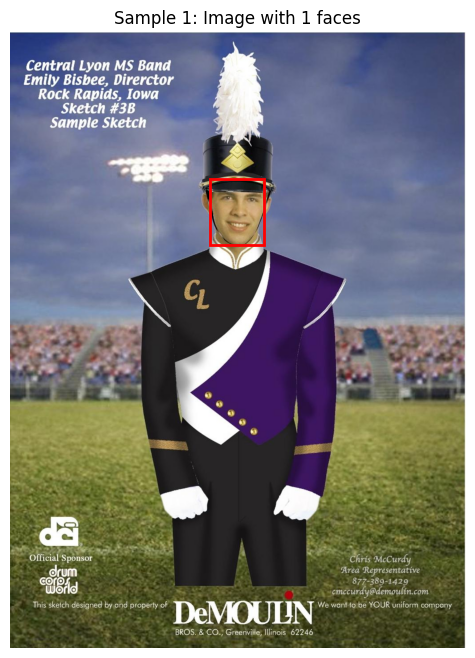

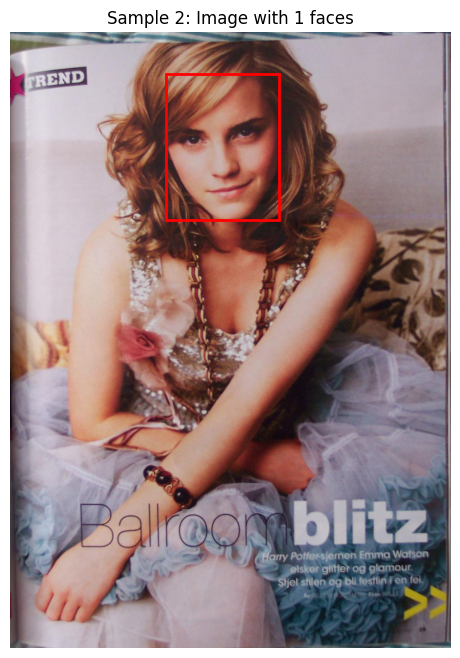

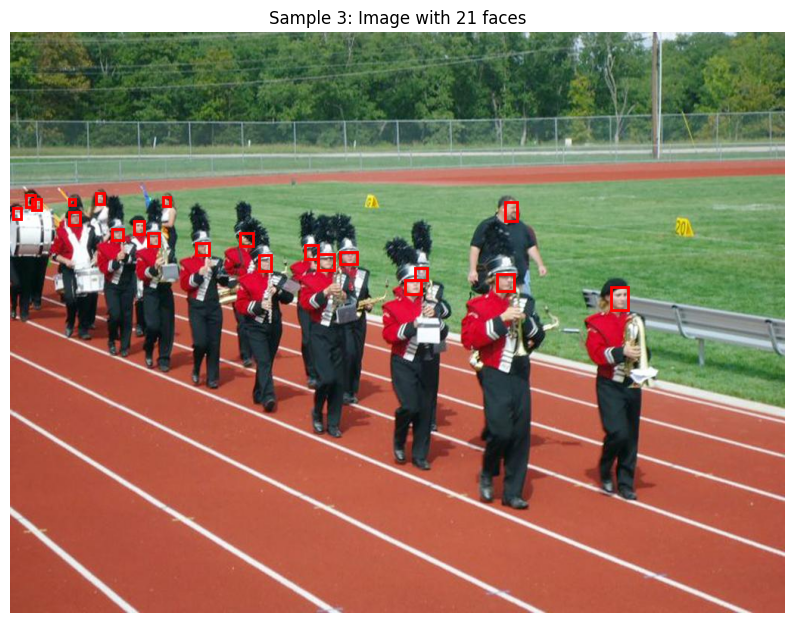


# Detailed Sample Exploration
Sample 10 information:
Image shape: (755, 1024, 3)
Number of faces: 6
Sample 10 information:
Image shape: (755, 1024, 3)
Number of faces: 6


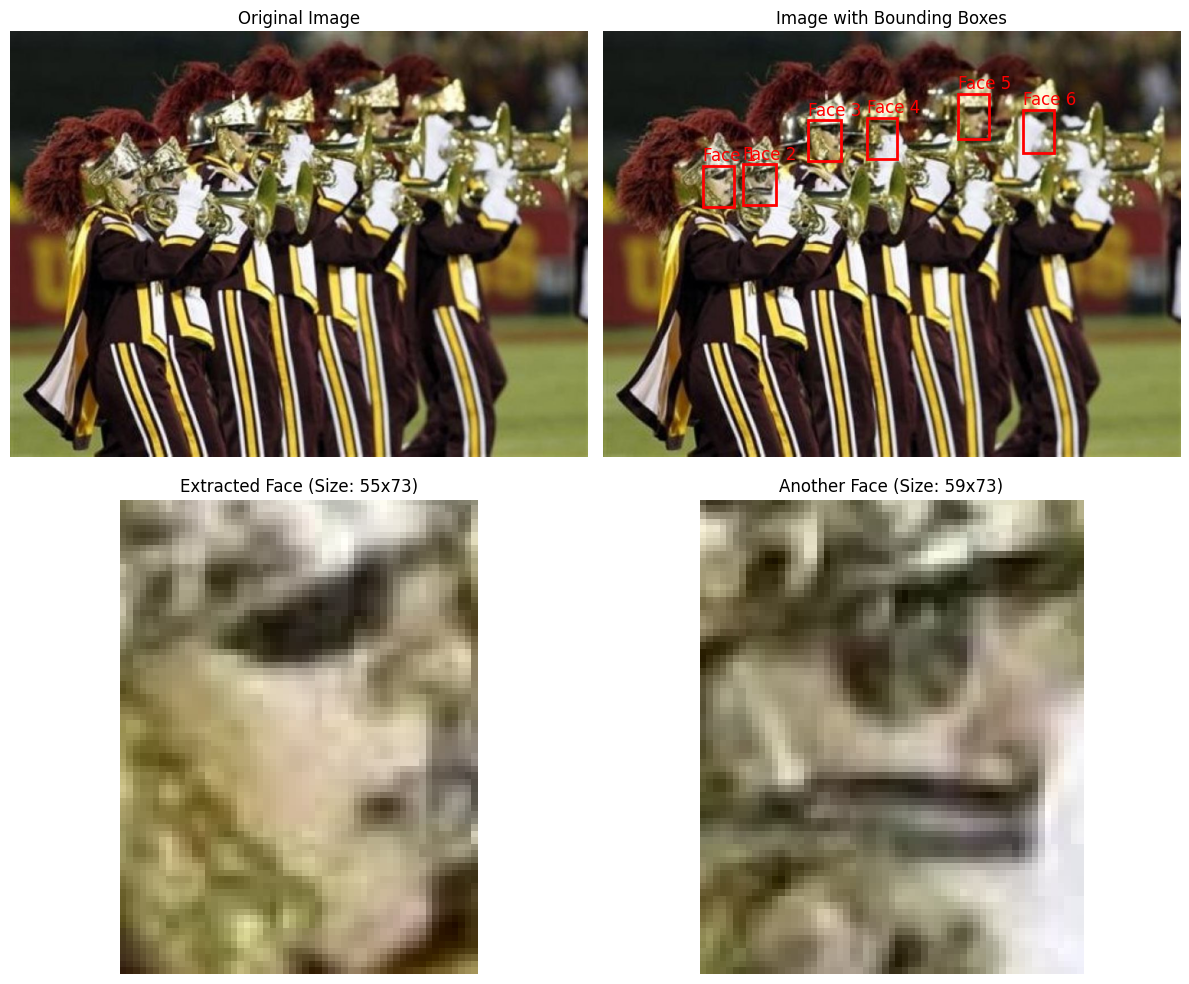


Dataset Statistics:


/usr/local/python/3.12.1/lib/python3.12/site-packages/deeplake/core/tensor.py:719: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


Average faces per image (first 100 images): 37.77

Image dimension statistics:
Average height: 851.22 pixels
Average width: 1024.00 pixels
Height range: 511 to 1583 pixels
Width range: 1024 to 1024 pixels

Face size statistics:
Average face width: 15.60 pixels
Average face height: 19.72 pixels
Face width range: 2.00 to 455.00 pixels
Face height range: 1.00 to 582.00 pixels


In [5]:
# 2. Dataset Access and Exploration - Using Activeloop public dataset

print("Accessing and exploring WIDER FACE dataset...")

# First completely uninstall deeplake to avoid version conflicts
#!pip uninstall -y deeplake hub

# Install the latest version of deeplake that should work with public datasets
#!pip install "deeplake<4"

# Import the freshly installed version
import importlib
import deeplake
importlib.reload(deeplake)
print(f"Installed Deeplake version: {deeplake.__version__}")

ds_train = deeplake.load('hub://activeloop/wider-face-train')
ds_val = deeplake.load('hub://activeloop/wider-face-val')

# Dataset Exploration and Visualization using Deeplake's API compatible with version 3.x
try:
    # Print dataset information
    print(f"Train dataset: {len(ds_train)} images")
    print(f"Validation dataset: {len(ds_val)} images")
    
    # Print available tensors
    print("\nAvailable tensors in the dataset:")
    tensor_keys = list(ds_train.tensors.keys())
    print(tensor_keys)
    
    # Display a few sample images with face bounding boxes
    # Using compatible API for Deeplake 3.x
    for idx in range(3):  # Show first 3 samples
        plt.figure(figsize=(10, 8))
        
        # Get and display image using direct indexing
        image = ds_train.images[idx].numpy()
        plt.imshow(image)
        
        # Get and display bounding boxes
        boxes = ds_train.boxes[idx].numpy()
        for box in boxes:
            x, y, width, height = box
            rect = plt.Rectangle((x, y), width, height, 
                               fill=False, edgecolor='red', linewidth=2)
            plt.gca().add_patch(rect)
        
        plt.title(f"Sample {idx+1}: Image with {len(boxes)} faces")
        plt.axis('off')
        plt.show()
    
    # Detailed example of a specific sample with its bounding box
    print("\n# Detailed Sample Exploration")
    
    # Get a sample with a clear face
    sample_idx = 10  # You can change this to explore different samples
    
    # Get image and boxes directly
    image = ds_train.images[sample_idx].numpy()
    boxes = ds_train.boxes[sample_idx].numpy()
    
    # Print detailed information
    print(f"Sample {sample_idx} information:")
    print(f"Image shape: {image.shape}")
    print(f"Number of faces: {len(boxes)}")
    
    # Plot original image
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')
    
    # Plot image with bounding boxes
    plt.subplot(2, 2, 2)
    plt.imshow(image)
    for i, box in enumerate(boxes):
        x, y, width, height = box
        rect = plt.Rectangle((x, y), width, height, 
                          fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)
        plt.text(x, y-10, f"Face {i+1}", color='red', fontsize=12)
    plt.title("Image with Bounding Boxes")
    plt.axis('off')
    
    # Extract and display face crops
    if len(boxes) > 0:
        plt.subplot(2, 2, 3)
        # Get the first face
        box = boxes[0]
        x, y, width, height = box
        # Convert to integers for slicing
        x, y, width, height = int(x), int(y), int(width), int(height)
        # Extract face region
        face = image[y:y+height, x:x+width]
        plt.imshow(face)
        plt.title(f"Extracted Face (Size: {width}x{height})")
        plt.axis('off')
        
        # If there are multiple faces, show another one
        if len(boxes) > 1:
            plt.subplot(2, 2, 4)
            box = boxes[1]
            x, y, width, height = box
            # Convert to integers for slicing
            x, y, width, height = int(x), int(y), int(width), int(height)
            # Extract face region
            face = image[y:y+height, x:x+width]
            plt.imshow(face)
            plt.title(f"Another Face (Size: {width}x{height})")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate dataset statistics efficiently
    print("\nDataset Statistics:")
    
    # Calculate statistics using direct access API
    total_faces = 0
    sample_count = 0
    heights = []
    widths = []
    face_widths = []
    face_heights = []
    
    # Using direct indexing for Deeplake 3.x
    # Process in batches to be more efficient
    batch_size = 10
    num_samples = min(100, len(ds_train))
    
    for batch_start in range(0, num_samples, batch_size):
        batch_end = min(batch_start + batch_size, num_samples)
        
        for idx in range(batch_start, batch_end):
            # Count faces
            boxes = ds_train.boxes[idx].numpy()
            total_faces += len(boxes)
            sample_count += 1
            
            # Track image dimensions
            if idx < 50:  # Get dimensions for first 50 images
                img = ds_train.images[idx].numpy()
                heights.append(img.shape[0])
                widths.append(img.shape[1])
            
            # Collect face dimensions
            for box in boxes:
                _, _, width, height = box
                face_widths.append(width)
                face_heights.append(height)
    
    # Calculate statistics
    avg_faces = total_faces / sample_count
    print(f"Average faces per image (first {sample_count} images): {avg_faces:.2f}")
    
    # Print image dimension statistics
    print("\nImage dimension statistics:")
    print(f"Average height: {sum(heights)/len(heights):.2f} pixels")
    print(f"Average width: {sum(widths)/len(widths):.2f} pixels")
    print(f"Height range: {min(heights)} to {max(heights)} pixels")
    print(f"Width range: {min(widths)} to {max(widths)} pixels")
    
    # Print face size statistics
    if face_widths:
        print("\nFace size statistics:")
        print(f"Average face width: {sum(face_widths)/len(face_widths):.2f} pixels")
        print(f"Average face height: {sum(face_heights)/len(face_heights):.2f} pixels")
        print(f"Face width range: {min(face_widths):.2f} to {max(face_widths):.2f} pixels")
        print(f"Face height range: {min(face_heights):.2f} to {max(face_heights):.2f} pixels")
    else:
        print("\nNo face data available in the analyzed samples")

except Exception as e:
    print(f"Error exploring dataset: {e}")
    print("\nMake sure 'ds_train' and 'ds_val' are defined. If they aren't, add this code before the try block:")
    print("ds_train = deeplake.load('hub://activeloop/wider-face-train')")
    print("ds_val = deeplake.load('hub://activeloop/wider-face-val')")

# 3. Data preparation for Model Training

Preparing dataset for face detection model...
Extracting samples from 2500 images...
Processing image 0/2500...
Processing image 100/2500...
Processing image 100/2500...
Processing image 200/2500...
Processing image 200/2500...
Processing image 300/2500...
Processing image 300/2500...
Processing image 400/2500...
Processing image 400/2500...
Processing image 500/2500...
Processing image 500/2500...
Processing image 600/2500...
Processing image 600/2500...
Processing image 700/2500...
Processing image 700/2500...
Processing image 800/2500...
Processing image 800/2500...
Processing image 900/2500...
Processing image 900/2500...
Processing image 1000/2500...
Processing image 1000/2500...
Processing image 1100/2500...
Processing image 1100/2500...
Processing image 1200/2500...
Processing image 1200/2500...
Processing image 1300/2500...
Processing image 1300/2500...
Processing image 1400/2500...
Processing image 1400/2500...
Processing image 1500/2500...
Processing image 1500/2500...
Proces

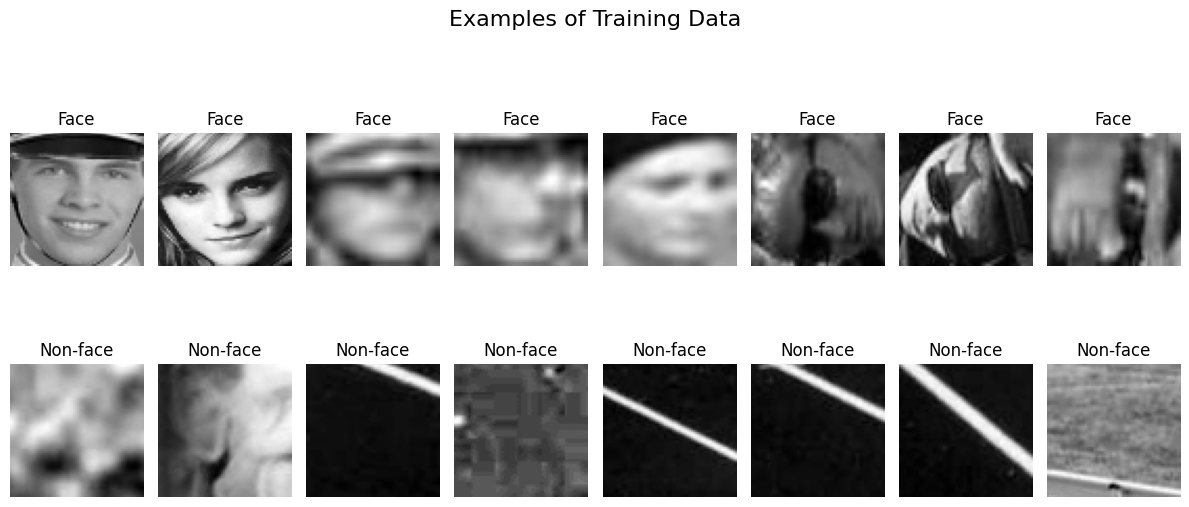

In [6]:
# 3. Data Preparation for Model Training

print("Preparing dataset for face detection model...")

# Define constants and parameters
FACE_SIZE = (64, 64)  # Standard size for all face/non-face samples
MAX_SAMPLES = 2500    # Ridotto da 5000 a 1000 per accelerare il training
NEGATIVE_PER_IMAGE = 8  # Number of negative samples per image

try:
    # Make sure dataset is loaded
    if 'ds_train' not in globals():
        print("Loading WIDER FACE dataset...")
        ds_train = deeplake.load('hub://activeloop/wider-face-train')
        ds_val = deeplake.load('hub://activeloop/wider-face-val')
    
    # Create lists to store face and non-face samples
    faces = []          # Will store face images
    non_faces = []      # Will store non-face images
    labels = []         # Will store labels (1 for face, 0 for non-face)
    
    # Process images to extract face and non-face regions
    num_samples = min(MAX_SAMPLES, len(ds_train))
    print(f"Extracting samples from {num_samples} images...")
    
    for idx in range(num_samples):
        if idx % 100 == 0:
            print(f"Processing image {idx}/{num_samples}...")
        
        # Get image and boxes
        image = ds_train.images[idx].numpy()
        boxes = ds_train.boxes[idx].numpy()
        
        # Skip images without faces
        if len(boxes) == 0:
            continue
        
        # Process each face in the image (positive samples)
        for box in boxes:
            x, y, width, height = box
            # Convert to integers for slicing
            x, y, width, height = int(x), int(y), int(width), int(height)
            
            # Skip very small faces
            if width < 20 or height < 20:
                continue
                
            # Extract face region
            face = image[y:y+height, x:x+width]
            
            # Resize to standard size
            try:
                face_resized = cv2.resize(face, FACE_SIZE)
                
                # Convert to grayscale if color
                if len(face_resized.shape) == 3:
                    face_gray = cv2.cvtColor(face_resized, cv2.COLOR_RGB2GRAY)
                else:
                    face_gray = face_resized
                
                faces.append(face_gray)
                labels.append(1)  # 1 for face
            except:
                # Skip faces that cause errors during resizing
                continue
        
        # Extract random non-face regions (negative samples)
        h, w = image.shape[0], image.shape[1]
        for _ in range(min(NEGATIVE_PER_IMAGE, len(boxes))):
            # Try to find non-overlapping regions
            max_attempts = 10
            found_valid = False
            
            for _ in range(max_attempts):
                # Generate random size (similar to face sizes)
                non_face_size = np.random.randint(40, 120)
                
                # Generate random position
                if w > non_face_size and h > non_face_size:
                    nx = np.random.randint(0, w - non_face_size)
                    ny = np.random.randint(0, h - non_face_size)
                    
                    # Check if this region overlaps with any face
                    overlaps = False
                    for box in boxes:
                        fx, fy, fw, fh = box
                        fx, fy = int(fx), int(fy)
                        
                        # Check for overlap
                        if not (nx > fx + fw or nx + non_face_size < fx or 
                                ny > fy + fh or ny + non_face_size < fy):
                            overlaps = True
                            break
                    
                    if not overlaps:
                        # Extract non-face region
                        non_face = image[ny:ny+non_face_size, nx:nx+non_face_size]
                        
                        # Resize to standard size
                        try:
                            non_face_resized = cv2.resize(non_face, FACE_SIZE)
                            
                            # Convert to grayscale if color
                            if len(non_face_resized.shape) == 3:
                                non_face_gray = cv2.cvtColor(non_face_resized, cv2.COLOR_RGB2GRAY)
                            else:
                                non_face_gray = non_face_resized
                            
                            non_faces.append(non_face_gray)
                            labels.append(0)  # 0 for non-face
                            found_valid = True
                            break
                        except:
                            continue
            
            if not found_valid:
                # If couldn't find non-overlapping region, just pick random
                if w > 64 and h > 64:
                    nx = np.random.randint(0, w - 64)
                    ny = np.random.randint(0, h - 64)
                    non_face = image[ny:ny+64, nx:nx+64]
                    
                    try:
                        non_face_resized = cv2.resize(non_face, FACE_SIZE)
                        if len(non_face_resized.shape) == 3:
                            non_face_gray = cv2.cvtColor(non_face_resized, cv2.COLOR_RGB2GRAY)
                        else:
                            non_face_gray = non_face_resized
                        
                        non_faces.append(non_face_gray)
                        labels.append(0)
                    except:
                        continue
    
    # Convert lists to numpy arrays
    X_faces = np.array(faces)
    X_non_faces = np.array(non_faces)
    y = np.array(labels)
    
    # Combine faces and non-faces into a single dataset
    X = np.vstack([X_faces, X_non_faces])
    
    print(f"Dataset created with {len(X_faces)} face samples and {len(X_non_faces)} non-face samples")
    
    # Display examples of face and non-face samples
    plt.figure(figsize=(12, 6))
    plt.suptitle("Examples of Training Data", fontsize=16)
    
    # Show face examples
    for i in range(min(8, len(X_faces))):
        plt.subplot(2, 8, i+1)
        plt.imshow(X_faces[i], cmap='gray')
        plt.title("Face")
        plt.axis('off')
    
    # Show non-face examples
    for i in range(min(8, len(X_non_faces))):
        plt.subplot(2, 8, 8+i+1)
        plt.imshow(X_non_faces[i], cmap='gray')
        plt.title("Non-face")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error during data preparation: {e}")
    import traceback
    traceback.print_exc()

# 4. Feature Extraction with HOG + LBP

In this section, we implement a combined feature extraction approach that uses both HOG (Histogram of Oriented Gradients) and LBP (Local Binary Patterns) features:

- HOG captures gradient orientation information, good for detecting shapes and edges
- LBP captures texture information and is highly resistant to illumination changes

By combining these complementary feature types, we should achieve better face detection performance.

Extracting HOG + LBP features from face and non-face samples...
Extracting combined HOG+LBP features...
Processing images 0 to 999 of 27084...
Current memory usage: 1099.69 MB
Processing images 1000 to 1999 of 27084...
Current memory usage: 1099.69 MB
Processing images 1000 to 1999 of 27084...
Current memory usage: 1099.69 MB
Processing images 2000 to 2999 of 27084...
Current memory usage: 1099.69 MB
Processing images 2000 to 2999 of 27084...
Current memory usage: 1099.69 MB
Processing images 3000 to 3999 of 27084...
Current memory usage: 1099.69 MB
Processing images 3000 to 3999 of 27084...
Current memory usage: 1105.94 MB
Processing images 4000 to 4999 of 27084...
Current memory usage: 1105.94 MB
Processing images 4000 to 4999 of 27084...
Current memory usage: 1119.82 MB
Processing images 5000 to 5999 of 27084...
Current memory usage: 1119.82 MB
Processing images 5000 to 5999 of 27084...
Current memory usage: 1133.69 MB
Processing images 6000 to 6999 of 27084...
Current memory usage:

Current memory usage: 1300.94 MB
Processing images 18000 to 18999 of 27084...
Current memory usage: 1314.82 MB
Processing images 19000 to 19999 of 27084...
Current memory usage: 1314.82 MB
Processing images 19000 to 19999 of 27084...
Current memory usage: 1328.82 MB
Processing images 20000 to 20999 of 27084...
Current memory usage: 1328.82 MB
Processing images 20000 to 20999 of 27084...
Current memory usage: 1342.82 MB
Processing images 21000 to 21999 of 27084...
Current memory usage: 1342.82 MB
Processing images 21000 to 21999 of 27084...
Current memory usage: 1356.69 MB
Processing images 22000 to 22999 of 27084...
Current memory usage: 1356.69 MB
Processing images 22000 to 22999 of 27084...
Current memory usage: 1370.69 MB
Processing images 23000 to 23999 of 27084...
Current memory usage: 1370.69 MB
Processing images 23000 to 23999 of 27084...
Current memory usage: 1384.57 MB
Processing images 24000 to 24999 of 27084...
Current memory usage: 1384.57 MB
Processing images 24000 to 2499

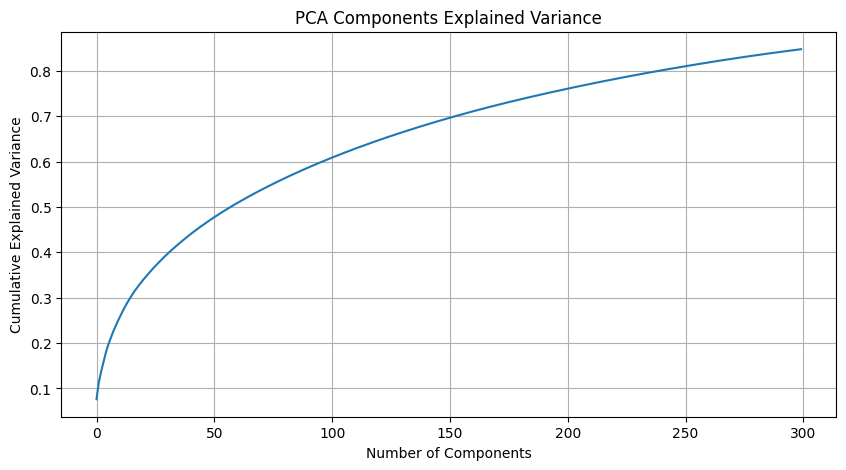

Saving processed HOG+LBP data...
Feature extraction with HOG+LBP complete!
Feature extraction with HOG+LBP complete!


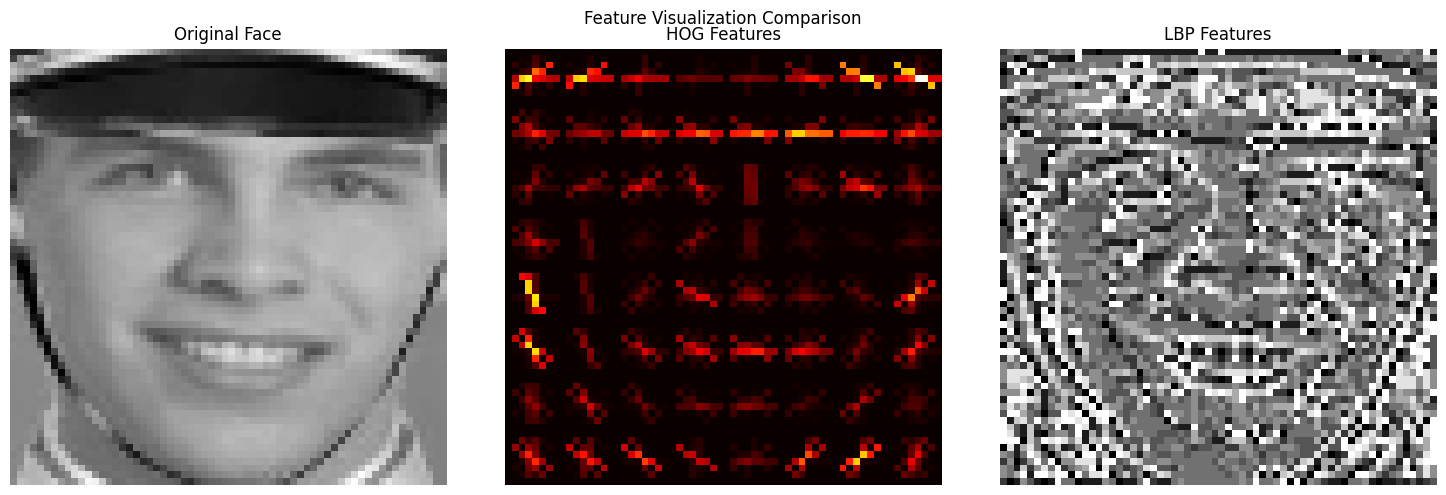

In [7]:
# 4 Feature Extraction with HOG + LBP

print("Extracting HOG + LBP features from face and non-face samples...")

try:
    # Funzione per ottimizzare la memoria
    def optimize_memory():
        """Force garbage collection and clear matplotlib cache to optimize memory usage."""
        import gc
        import matplotlib.pyplot as plt
        
        # Close all matplotlib figures
        plt.close('all')
        
        # Run garbage collection multiple times to ensure cleanup
        for _ in range(3):
            gc.collect()
        
        # Print memory usage if psutil is available
        try:
            import psutil
            process = psutil.Process()
            memory_info = process.memory_info()
            print(f"Current memory usage: {memory_info.rss / (1024 * 1024):.2f} MB")
        except ImportError:
            pass

    # Function to extract both HOG and LBP features in batches to optimize memory usage
    def extract_hog_lbp_features_in_batches(images, batch_size=1000):  # Aumentato il batch_size da 500 a 1000
        total_images = len(images)
        features = []
        
        # Process images in batches
        for batch_start in range(0, total_images, batch_size):
            batch_end = min(batch_start + batch_size, total_images)
            print(f"Processing images {batch_start} to {batch_end-1} of {total_images}...")
            
            batch_features = []
            for img in images[batch_start:batch_end]:
                # Normalize image if needed
                if img.max() > 1.0:
                    img = img / 255.0
                
                # 1. Extract HOG features
                hog_feat = hog(img, orientations=9, 
                               pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2), 
                               visualize=False,
                               feature_vector=True)
                
                # 2. Extract LBP features
                # Convert to uint8 to avoid skimage warning
                if img.max() <= 1.0:
                    img_uint8 = (img * 255).astype(np.uint8)
                else:
                    img_uint8 = img.astype(np.uint8)
                lbp = local_binary_pattern(img_uint8, P=8, R=1, method='uniform')
				
                # Compute histogram of LBP values (uniform method has 59 output values)
                n_bins = 59  # for uniform LBP with P=8
                hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
                
                # 3. Combine HOG and LBP features
                combined_feat = np.concatenate([hog_feat, hist])
                batch_features.append(combined_feat)
            
            # Add batch features to main list
            features.extend(batch_features)
            
            # Force memory cleanup
            optimize_memory()
            
        return np.array(features)
    
    # Extract HOG+LBP features in batches
    print("Extracting combined HOG+LBP features...")
    X_features = extract_hog_lbp_features_in_batches(X, batch_size=1000)  # Aumentato il batch_size da 500 a 1000
    
    print(f"Combined feature vector shape: {X_features.shape}")
    
    # Split data - handle memory carefully
    print("Splitting data into train/validation/test sets (60/20/20)...")
    
    # First split: 60% train, 40% temp
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_features, y, test_size=0.4, random_state=42, stratify=y
    )
    
    # Release X_features from memory
    del X_features
    optimize_memory()
    
    # Second split: split temp into validation and test (50/50)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    # Release X_temp from memory
    del X_temp, y_temp
    optimize_memory()
    
    print(f"Training set: {X_train.shape} ({len(X_train)} samples)")
    print(f"Validation set: {X_val.shape} ({len(X_val)} samples)")
    print(f"Test set: {X_test.shape} ({len(X_test)} samples)")
    
    # Apply PCA for dimensionality reduction with memory optimization
    apply_pca = True
    if apply_pca:
        n_components = min(300, X_train.shape[1])
        print(f"Applying PCA to reduce dimensions to {n_components}...")
        
        # Apply PCA with randomized solver for efficiency
        pca = PCA(n_components=n_components, svd_solver='randomized', random_state=42)
        
        # Transform data
        X_train_pca = pca.fit_transform(X_train)
        X_val_pca = pca.transform(X_val)
        X_test_pca = pca.transform(X_test)
        
        print(f"Explained variance: {sum(pca.explained_variance_ratio_):.4f}")
        
        # Visualize explained variance
        plt.figure(figsize=(10, 5))
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('PCA Components Explained Variance')
        plt.grid(True)
        plt.show()
    else:
        X_train_pca = X_train
        X_val_pca = X_val
        X_test_pca = X_test
    
    # Save the processed data
    print("Saving processed HOG+LBP data...")
    np.savez('face_detection_hog_lbp_data.npz', 
             X_train=X_train_pca,
             X_val=X_val_pca, 
             X_test=X_test_pca, 
             y_train=y_train,
             y_val=y_val, 
             y_test=y_test,
             feature_type="HOG+LBP")  # Add metadata about feature type
    
    # Save the PCA model if applied
    if apply_pca:
        import pickle
        with open('face_pca_hog_lbp_model.pkl', 'wb') as f:
            pickle.dump(pca, f)
    
    print("Feature extraction with HOG+LBP complete!")
    
    # Visualize a sample HOG and LBP representation for comparison
    if len(X_faces) > 0:
        sample_face = X_faces[0]
        
        plt.figure(figsize=(15, 5))
        
        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(sample_face, cmap='gray')
        plt.title('Original Face')
        plt.axis('off')
        
        # HOG visualization
        plt.subplot(1, 3, 2)
        hog_image = hog(sample_face/255.0, orientations=9, 
                       pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), 
                       visualize=True)[1]
        plt.imshow(hog_image, cmap='hot')
        plt.title('HOG Features')
        plt.axis('off')
        
        # LBP visualization
        plt.subplot(1, 3, 3)
        if sample_face.max() <= 1.0:
             sample_face_uint8 = (sample_face * 255).astype(np.uint8)
        else:
            sample_face_uint8 = sample_face.astype(np.uint8)
        lbp_image = local_binary_pattern(sample_face_uint8, P=8, R=1, method='uniform')
        plt.imshow(lbp_image, cmap='gray')
        plt.title('LBP Features')
        plt.axis('off')
        
        plt.suptitle('Feature Visualization Comparison')
        plt.tight_layout()
        plt.show()
    
except Exception as e:
    print(f"Error during HOG+LBP feature extraction: {e}")
    import traceback
    traceback.print_exc()

# 5. Model Training and Validation

In this section, we will train and validate three different classifiers for face detection:

- Support Vector Machine (SVM)
- Random Forest
- Stochastic Gradient Descent Classifier (SGDClassifier)

We will compare their performance on the validation set and select the best model.

In [8]:
# Model Training and Validation - Fast Version with RandomizedSearchCV

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    metrics = {
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred),
        'recall': recall_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred),
        'report': classification_report(y_val, y_pred)
    }
    return metrics

# Param grids (ridotti per velocità)
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    #'Bagging': {
    #    'n_estimators': [30, 50, 100]
    #}
}

results_all = {}

for feature_type, Xtr, Xv, ytr, yv in [
    ("HOG+LBP", X_train_pca, X_val_pca, y_train, y_val),
]:
    print(f"\n--- Fast model selection with {feature_type} features ---")
    results = {}

    # Random Forest
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    rf_search = RandomizedSearchCV(rf, param_grids['Random Forest'], n_iter=4, cv=3, scoring='f1', random_state=42, n_jobs=-1)
    results['Random Forest'] = evaluate_model(rf_search, Xtr, ytr, Xv, yv)
    print("Random Forest best params:", rf_search.best_params_)

    # Gradient Boosting
    gb = GradientBoostingClassifier(random_state=42)
    gb_search = RandomizedSearchCV(gb, param_grids['Gradient Boosting'], n_iter=4, cv=3, scoring='f1', random_state=42, n_jobs=-1)
    results['Gradient Boosting'] = evaluate_model(gb_search, Xtr, ytr, Xv, yv)
    print("Gradient Boosting best params:", gb_search.best_params_)

    # Bagging - Ho fatto una prova e i risultati non erano buoni, quindi lo escludo
    # bag = BaggingClassifier(random_state=42, n_jobs=-1)
    # bag_search = RandomizedSearchCV(bag, param_grids['Bagging'], n_iter=3, cv=3, scoring='f1', random_state=42, n_jobs=-1)
    # results['Bagging'] = evaluate_model(bag_search, Xtr, ytr, Xv, yv)
    # print("Bagging best params:", bag_search.best_params_)

    results_all[feature_type] = results

    # Print results
    for model_name, metrics in results.items():
        print(f"\nModel: {model_name}")
        print(f"Validation Accuracy: {metrics['accuracy']:.4f}")
        print(f"Validation Precision: {metrics['precision']:.4f}")
        print(f"Validation Recall: {metrics['recall']:.4f}")
        print(f"Validation F1-score: {metrics['f1']:.4f}")
        print("Classification Report:")
        print(metrics['report'])

# Top models recap
best_models = []
for feature_type, models in results_all.items():
    for model_name, metrics in models.items():
        best_models.append({
            'feature_type': feature_type,
            'model_name': model_name,
            **metrics
        })

best_models = sorted(best_models, key=lambda x: x['f1'], reverse=True)

print("\n=== Top 2 Models Recap ===")
for i, model in enumerate(best_models[:2], 1):
    print(f"\n--- Model #{i} ---")
    print(f"Feature type: {model['feature_type']}")
    print(f"Model: {model['model_name']}")
    print(f"Validation Accuracy: {model['accuracy']:.4f}")
    print(f"Validation Precision: {model['precision']:.4f}")
    print(f"Validation Recall: {model['recall']:.4f}")
    print(f"Validation F1-score: {model['f1']:.4f}")
    print("Classification Report:")
    print(model['report'])

# Note:
# - SVM e SGD sono esclusi per velocità, ma puoi aggiungerli se vuoi.
# - RandomizedSearchCV usa pochi parametri e pochi iter per rapidità.
# - Usa solo 3-fold


--- Fast model selection with HOG+LBP features ---
Random Forest best params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 20}
Random Forest best params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 20}
Gradient Boosting best params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.05}

Model: Random Forest
Validation Accuracy: 0.5498
Validation Precision: 0.5614
Validation Recall: 0.9124
Validation F1-score: 0.6951
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.08      0.14      2370
           1       0.56      0.91      0.70      3047

    accuracy                           0.55      5417
   macro avg       0.49      0.50      0.42      5417
weighted avg       0.50      0.55      0.45      5417


Model: Gradient Boosting
Validation Accuracy: 0.5616
Validation Precision: 0.5625
Validation Recall: 0.9925
Validation F1-score: 0.7180
Classification Report:
              precision    recall 

In [9]:
# Dopo la cella dove hai best_models (subito dopo la selezione e stampa dei risultati)

# Seleziona il modello migliore da best_models (cella 11)
# Assumiamo che il primo elemento sia quello col miglior F1-score
best_model_name = best_models[0]['model_name']

if best_model_name == 'Random Forest':
    best_clf = rf_search.best_estimator_
elif best_model_name == 'Gradient Boosting':
    best_clf = gb_search.best_estimator_
else:
    raise ValueError(f"Modello migliore non riconosciuto: {best_model_name}")

print(f"Modello selezionato per la detection: {best_model_name}")

Modello selezionato per la detection: Gradient Boosting


# 6. Sliding window

In [10]:
# --- Sliding Window + Multiscale Detection (Step Successivo) ---

import cv2
from skimage.transform import pyramid_gaussian

def sliding_window(image, window_size=(64, 64), step_size=48):
    """Yield top-left x, y, and window of the image."""
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def detect_faces_in_image(
    image, 
    clf, 
    pca, 
    scaler=None, 
    window_size=(64, 64), 
    step_size=48, 
    downscale=2.0, 
    min_size=(64, 64), 
    threshold=0.5
):
    """
    Esegue la face detection su un'immagine usando sliding window e piramide multiscala.
    Restituisce una lista di bounding box [x, y, w, h] dove sono stati rilevati volti.
    """
    boxes = []
    scale = 0
    for resized in pyramid_gaussian(image, downscale=downscale, channel_axis=-1):
        if resized.shape[0] < min_size[1] or resized.shape[1] < min_size[0]:
            break
        # Converti in grayscale se serve
        if len(resized.shape) == 3:
            gray = cv2.cvtColor((resized * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        else:
            gray = (resized * 255).astype(np.uint8)
        for (x, y, window) in sliding_window(gray, window_size, step_size):
            if window.shape != window_size:
                continue
            # Estrai feature HOG+LBP
            img = window / 255.0
            hog_feat = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False, feature_vector=True)
            img_uint8 = (img * 255).astype(np.uint8)
            lbp = local_binary_pattern(img_uint8, P=8, R=1, method='uniform')
            n_bins = 59
            hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
            feat = np.concatenate([hog_feat, hist]).reshape(1, -1)
            # PCA e scaling se necessario
            if pca is not None:
                feat = pca.transform(feat)
            if scaler is not None:
                feat = scaler.transform(feat)
            # Predizione
            prob = clf.predict_proba(feat)[0, 1] if hasattr(clf, "predict_proba") else clf.decision_function(feat)[0]
            if prob > threshold:
                # Calcola coordinate rispetto all'immagine originale
                scale_factor = downscale ** scale
                x_orig = int(x * scale_factor)
                y_orig = int(y * scale_factor)
                w_orig = int(window_size[0] * scale_factor)
                h_orig = int(window_size[1] * scale_factor)
                boxes.append([x_orig, y_orig, w_orig, h_orig, prob])
        scale += 1
    return boxes

# Esempio di utilizzo:
# image = ... # Carica un'immagine RGB (0-255)
# boxes = detect_faces_in_image(image, best_clf, pca, window_size=(64,64), step_size=16)
# print("Bounding boxes:", boxes)

# 7. Non-Maximum Suppression (NMS) e funzione di inferenza end-to-end 

In [11]:
# --- Non-Maximum Suppression (NMS) e funzione di inferenza end-to-end ---

import numpy as np

def non_max_suppression(boxes, overlapThresh=0.3):
    """
    boxes: list of [x, y, w, h, score]
    Restituisce solo i box non sovrapposti (NMS).
    """
    if len(boxes) == 0:
        return []
    boxes = np.array(boxes)
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,0] + boxes[:,2]
    y2 = boxes[:,1] + boxes[:,3]
    scores = boxes[:,4]

    idxs = np.argsort(scores)[::-1]
    keep = []
    while len(idxs) > 0:
        i = idxs[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[1:]])
        yy1 = np.maximum(y1[i], y1[idxs[1:]])
        xx2 = np.minimum(x2[i], x2[idxs[1:]])
        yy2 = np.minimum(y2[i], y2[idxs[1:]])
        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)
        inter = w * h
        area_i = (x2[i] - x1[i]) * (y2[i] - y1[i])
        area_others = (x2[idxs[1:]] - x1[idxs[1:]]) * (y2[idxs[1:]] - y1[idxs[1:]])
        union = area_i + area_others - inter
        iou = inter / (union + 1e-6)
        idxs = idxs[1:][iou <= overlapThresh]
    return boxes[keep].tolist()

def predict_faces(image, clf, pca, scaler=None, window_size=(64,64), step_size=16, downscale=1.25, min_size=(64,64), threshold=0.5, nms_thresh=0.3):
    """
    Esegue la face detection completa su un'immagine:
    - Sliding window multiscala
    - Non-Maximum Suppression
    Restituisce i bounding box finali [x, y, w, h, score].
    """
    raw_boxes = detect_faces_in_image(
        image, clf, pca, scaler, window_size, step_size, downscale, min_size, threshold
    )
    final_boxes = non_max_suppression(raw_boxes, overlapThresh=nms_thresh)
    return final_boxes

# Esempio di utilizzo:
# image = ... # Carica un'immagine RGB (0-255)
# boxes = predict_faces(image, best_clf, pca)
# for (x, y, w, h, score) in boxes:
#     print(f"Face at ({x},{y},{w},{h}) with score

# 9. Valutazione finale

Valutazione su 20 immagini del validation set:
Precision media: 0.002
Recall media: 0.108
F1-score medio: 0.004
Totale TP: 17, FP: 9190, FN: 887


Text(0.5, 1.0, 'Ultima immagine: Predetti (verde) vs GT (rosso tratteggiato)\nPrecision: 0.00 Recall: 0.00')

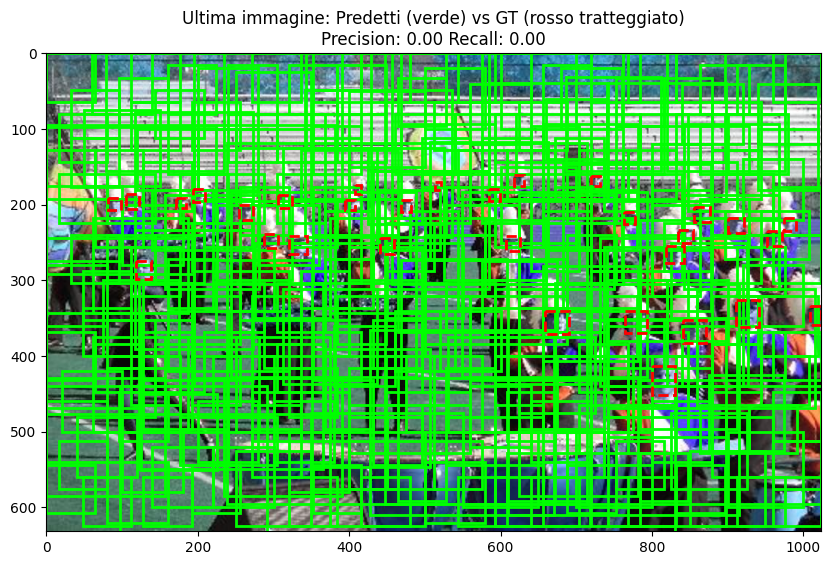

In [12]:
# --- Valutazione quantitativa su batch di immagini del validation set: Precision, Recall, F1, IoU ---

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2

def compute_iou(boxA, boxB):
    """Compute Intersection over Union (IoU) between two boxes [x, y, w, h]."""
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0]+boxA[2], boxB[0]+boxB[2])
    yB = min(boxA[1]+boxA[3], boxB[1]+boxB[3])
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou

def match_boxes(pred_boxes, gt_boxes, iou_threshold=0.5):
    """Match predicted boxes to ground truth boxes using IoU."""
    matched_pred = set()
    matched_gt = set()
    for i, gt in enumerate(gt_boxes):
        for j, pred in enumerate(pred_boxes):
            if j in matched_pred:
                continue
            iou = compute_iou(pred[:4], gt)
            if iou >= iou_threshold:
                matched_pred.add(j)
                matched_gt.add(i)
                break
    TP = len(matched_gt)
    FP = len(pred_boxes) - TP
    FN = len(gt_boxes) - TP
    return TP, FP, FN

# Valutazione su batch di immagini del validation set
num_images = 20  # Puoi aumentare per una valutazione più robusta
all_TP, all_FP, all_FN = 0, 0, 0
precisions, recalls, f1s = [], [], []

for idx in range(num_images):
    image = ds_val.images[idx].numpy()
    gt_boxes = ds_val.boxes[idx].numpy().astype(int)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pred_boxes = predict_faces(image_rgb, best_clf, pca, window_size=(64,64), step_size=16, threshold=0.5, nms_thresh=0.3)
    TP, FP, FN = match_boxes(pred_boxes, gt_boxes, iou_threshold=0.5)
    all_TP += TP
    all_FP += FP
    all_FN += FN
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

# Metriche aggregate
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1 = np.mean(f1s)

print(f"Valutazione su {num_images} immagini del validation set:")
print(f"Precision media: {mean_precision:.3f}")
print(f"Recall media: {mean_recall:.3f}")
print(f"F1-score medio: {mean_f1:.3f}")
print(f"Totale TP: {all_TP}, FP: {all_FP}, FN: {all_FN}")

# Visualizza l'ultima immagine valutata con predizioni e ground truth
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
ax = plt.gca()
for (x, y, w, h, score) in pred_boxes:
    rect = Rectangle((x, y), w, h, fill=False, edgecolor='lime', linewidth=2)
    ax.add_patch(rect)
for (x, y, w, h) in gt_boxes:
    rect = Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2, linestyle='--')
    ax.add_patch(rect)
plt.title(f"Ultima immagine: Predetti (verde) vs GT (rosso tratteggiato)\nPrecision: {precision:.2f} Recall: {recall:.2f}")